In [1]:
import numpy as np
import matplotlib.pylab as plt
np.random.seed(10)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
  

In [2]:
num_train = 30000000 #15000000
num_train = 50000000 #FSPSall

num_test = 20000

In [3]:
num_train2 = 250000 #15000000
num_test2 = 20000

In [4]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS'][2]
Trainset2 = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS'][3]

Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS'][3]

In [5]:
# ## BEST ONE SO FAR - fsps-lin train obs test ### no cutoff on train
# n_epochs = 10
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3 #16 # number of mixture components

# learning_rate = 5e-1
# decay_rate= 1e-2
# step= 100
# batch_size = 32768 # 8192 # 1024  # 65536 #32768 #16384 #

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_batch'+str(batch_size)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [6]:
## BEST ONE SO FAR - fsps-all train obs test ###
n_epochs = 10
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 #16 # number of mixture components

learning_rate = 1e-1
decay_rate= 1e-3
step= 5
batch_size = 131072 #32768 # 8192 # 1024  # 65536 #32768 #16384 #

save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_batch'+str(batch_size)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [7]:
# ## BEST ONE SO FAR - fsps-log train obs test ###
# n_epochs = 16
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 2  #16 # number of mixture components

# learning_rate = 1e-2
# decay_rate= 1e-2
# step=1#100
# batch_size = 50000 #32768 #16384 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [8]:
## BEST ONE SO FAR - obs train obs test ###
n_epochs2 = 128
D2 = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K2 = 2  #16 # number of mixture components

learning_rate2 = 1e-2
decay_rate2= 1e-3
step2=4#100
batch_size2 = 64 #1024 #8192 #50000 #32768 #16384 #8192 # 

save_mod2 = 'saved_hubs/new_tf2/'+'Train_'+Trainset2+'_lr_'+str(learning_rate2)+'_dr'+str(decay_rate2)+'_step'+str(step2)+'_ne'+str(n_epochs2)+'_k'+str(K2)+'_nt'+str(num_train2)

In [9]:
def minmax_cuts(X, y):
    # print(X.shape)
    min_col = -5
    max_col = 5
    min_mag = 12
    max_mag = 25
    min_z = 0.0
    max_z = 1.25
    
    mask_cond =  np.where( 
        (X[:, 0] < max_col) & (X[:, 0] > min_col) &
        (X[:, 1] < max_col) & (X[:, 1] > min_col) &
        (X[:, 2] < max_col) & (X[:, 2] > min_col) &
        (X[:, 3] < max_col) & (X[:, 3] > min_col) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    
    # print( np.array(mask_cond).shape)

    X_new = X[mask_cond]
    y_new = y[mask_cond]
    # print(X_new.shape)
    return X_new, y_new

In [10]:
def rescale(X, y):
    # xmin = np.array([-5, -5, -5, -5, 12])
    # xmax =  np.array([5, 5, 5, 5, 25])
    # ymin = 0.0
    # ymax = 1.25

    X_new = (X - xmin)/(xmax - xmin)
    y_new = (y - ymin)/(ymax - ymin)
    return X_new, y_new 

In [11]:
def print_limits(X, y):
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))

In [12]:
def shuffle(X, y):
    np.random.seed(12211)  
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y

In [13]:

def ReadFSPS_raw(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    
    fsps_ip = np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_col_mag.npy')
    # (ngal, nprop, nredshift, ncol)
    ngal, nprop, nz, ncol = fsps_ip.shape
    fsps_reshaped = fsps_ip.reshape(-1, nz, ncol)
    fsps_reshaped = fsps_reshaped.reshape(-1, ncol)

    fsps_ip_z= np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_zz.npy')
    ngal, nprop, nz = fsps_ip_z.shape
    fsps_z_reshaped = fsps_ip_z.reshape(-1, nz)
    fsps_z_reshaped = fsps_z_reshaped.reshape(-1)

    fsps_ip_flag = np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_flag_zz.npy')
    ngal, nprop, nz = fsps_ip_flag.shape
    fsps_flag_reshaped = fsps_ip_flag.reshape(-1, nz)
    fsps_flag_reshaped = fsps_flag_reshaped.reshape(-1)

    if Trainset == 'FSPSlin':
        z_index = (fsps_flag_reshaped == 0)
    elif Trainset == 'FSPSlog':
        z_index = (fsps_flag_reshaped == 1)
    elif Trainset == 'FSPSall':
        z_index = (fsps_flag_reshaped != 2)
    else: 
        z_index = (fsps_flag_reshaped != 3)

    Trainfiles = np.append(fsps_z_reshaped[z_index][:, None], fsps_reshaped[z_index], axis=1) 

    X_FSPS = Trainfiles[:, 1:]  # color mag
    y_FSPS = Trainfiles[:, 0]  # spec z

    ##################################################
   
    TestOBS = True
    if TestOBS:

        fileIn_col = path_program + 'data_apr_2020/obs_cols.npy'
        fileIn_z = path_program + 'data_apr_2020/obs_zz.npy'
        

        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        X_OBS = Testfiles[:, 1:]  # color mag
        y_OBS = Testfiles[:, 0] # spec z
    

    ############################################################

    print('OBS')
    print_limits(X_OBS, y_OBS)

    
    ##### min-max cuts #####

    # X_FSPS, y_FSPS = minmax_cuts(X_FSPS, y_FSPS)
    X_OBS, y_OBS = minmax_cuts(X_OBS, y_OBS)

    print('FSPS')
    print_limits(X_FSPS, y_FSPS)
    print('OBS')
    print_limits(X_OBS, y_OBS)

    ##### shuffle #####

    X_FSPS, y_FSPS = shuffle(X_FSPS, y_FSPS)
    X_OBS, y_OBS = shuffle(X_OBS, y_OBS)

    return X_FSPS, y_FSPS, X_OBS, y_OBS

In [14]:
_, _, X_OBS, y_OBS = ReadFSPS_raw(path_program = '../../Data/fromGalaxev/photozs/datasets/')

OBS
number of datapoints:  271860
z-minmax:  5.843881822897856e-08 7.011244773864746
ColMag-min:  [-16.02178146  -8.86878939  -1.98356056 -16.55613166  11.09888744]
ColMag-max:  [17.02883987 20.22452066  8.5757395   2.73801613 22.99328526]
FSPS
number of datapoints:  34721211
z-minmax:  0.002000010024108306 1.2499997501080744
ColMag-min:  [-0.1784067  -0.58599727 -1.97231054 -1.77934106  5.12664693]
ColMag-max:  [  3.79654048   3.23352432   1.89477147   2.41539175 102.21784816]
OBS
number of datapoints:  271050
z-minmax:  5.843881822897856e-08 1.246999979019165
ColMag-min:  [-4.25878525 -3.89014053 -1.98356056 -4.82941818 12.01159477]
ColMag-max:  [ 4.99607277  4.97422409  4.18241501  2.73801613 22.99328526]


In [15]:
xmin = np.array([-5, -5, -5, -5, 12])
xmax =  np.array([5, 5, 5, 5, 25])
ymin = 0.0
ymax = 1.0 #1.25

rescaleTrue = True
if rescaleTrue:
    
    # X_FSPS, y_FSPS = rescale(X_FSPS, y_FSPS)
    X_OBS, y_OBS = rescale(X_OBS, y_OBS)


In [16]:
# if (Trainset != Testset):
    # if Trainset == 'FSPSlin':
    #     Trainz_sample = 'Linear'
    #     X_train = X_FSPS[: num_train, :]
    #     y_train = y_FSPS[: num_train]
        
    # if Trainset == 'FSPSlog':
    #     Trainz_sample = 'Log'
    #     X_train = X_FSPS[: num_train, :]
    #     y_train = y_FSPS[: num_train]

    # if Trainset == 'FSPSall':
    #     Trainz_sample = 'All'
    #     X_train = X_FSPS[: num_train, :]
    #     y_train = y_FSPS[: num_train]


    # if Testset == 'OBS':
    #     X_test = X_OBS[: num_test, :]
    #     y_test = y_OBS[: num_test]



In [17]:
# if (Trainset == Testset):
        
if Testset == 'OBS':
    # X_train = X_OBS[: num_train, :]
    # y_train = y_OBS[: num_train]

    X_test = X_OBS[num_train2+1: num_train2 + num_test2 + 1, :]
    y_test = y_OBS[num_train2+1: num_train2 + num_test2 + 1]


In [18]:

# print("Size of features in training data: {}".format(X_train.shape))
# print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (20000, 5)
Size of output in test data: (20000,)


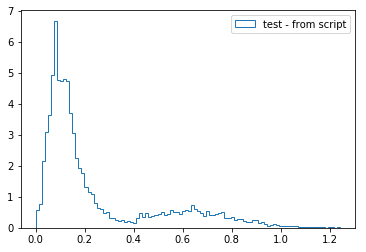

In [19]:
plt.figure(23)
# y_t = 10**(ymax - ymin)*(ymin + y_test)
y_t =  y_test
# y_tr =  y_train

# plt.hist(y_tr, normed=True, bins = 100, histtype='step', label='train - from script')
plt.hist(y_t, normed=True, bins = 100, histtype='step', label='test - from script')
plt.legend()

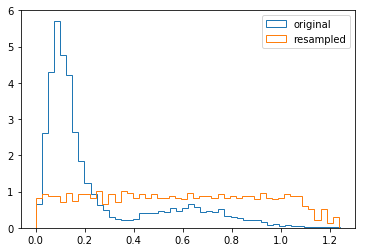

In [20]:
reSampleTest = True
if reSampleTest :
    # test_argsort = np.argsort(y_test)
    # y_test = y_test[test_argsort]
    # X_test = X_test[test_argsort]

    num_y_test_select_per_bin = 10
    n_bins = 100
    np.random.seed(1)

    bins = np.linspace(y_test.min(), y_test.max(), n_bins)
    # bins = np.logspace(np.log10(y_test.min()+1e-2), np.log10(y_test.max()+1e-2), n_bins)
    inds = np.digitize(y_test, bins)

    # print(bins)
    # print(inds.shape, inds.max())
    # hist_y = np.histogram(y_test, bins = bins)
    # plt.plot(inds)
    # plt.plot(hist_y[0], '-.')
    # plt.yscale('log')

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [num_y_test_select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')


    plt.figure(23)
    plt.hist(y_test, normed=True, bins = 50, histtype='step', label='original')
    y_test1 = y_test[resampled_ind]
    X_test1 = X_test[resampled_ind]

    plt.hist(y_test1, normed=True, bins = 50, histtype='step', label='resampled')
    plt.legend()
    plt.show()

    # print(int_select)




In [21]:
if reSampleTest :
    y_test = y_test1
    X_test = X_test1

In [22]:
PairPlotTrue = False

if PairPlotTrue:
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    ############ loading data ############
    # num_train = 800000

    # _, _, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = False)

    # print("Size of features in training data: {}".format(X_train.shape))
    # print("Size of output in training data: {}".format(y_train.shape))
    # print("Size of features in test data: {}".format(X_test.shape))
    # print("Size of output in test data: {}".format(y_test.shape))

    num_data = 2000

    df_train = pd.DataFrame()

    # Add columns
    df_train['u-g'] = X_train[:num_data, 0]
    df_train['g-r'] = X_train[:num_data, 1]
    df_train['r-i'] = X_train[:num_data, 2]
    df_train['i-z'] = X_train[:num_data, 3]
    df_train['mag(i)'] = X_train[:num_data, 4]
    df_train['redshift'] = y_train[:num_data]


    df_test = pd.DataFrame()

    # Add columns
    df_test['u-g'] = X_test[:num_data, 0]
    df_test['g-r'] = X_test[:num_data, 1]
    df_test['r-i'] = X_test[:num_data, 2]
    df_test['i-z'] = X_test[:num_data, 3]
    df_test['mag(i)'] = X_test[:num_data, 4]
    df_test['redshift'] = y_test[:num_data]


    df_all = pd.concat([df_train.assign(dataset='train'), df_test.assign(dataset='test')])


    #### plotting ####
    g = sns.PairGrid(df_all, hue='dataset')
    g = g.map_upper(sns.scatterplot, alpha=0.5)
    g = g.map_lower(sns.kdeplot, n_levels=6, shade=True, shade_lowest=False, alpha=0.7)
    g = g.map_diag(sns.kdeplot, lw=2, shade=True)
    # g = g.map_diag(sns.distplot, hist=True, kde=False)
    g = g.add_legend()

    g.savefig("pairplot_sdss_deep.png")

    plt.clf() # Clean parirplot figure from sns 
    Image(filename='pairplot_sdss_deep.png') # Show pairplot as image

    # plt.show()

In [23]:
output_shape = 1 

model_train = keras.Sequential([
    keras.layers.Dense(units=256, activation='relu', input_shape=(D,)),
    keras.layers.Dense(units=1024, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    # keras.layers.Dropout(0.4),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
    tfp.layers.MixtureNormal(K, output_shape)])


model_train2 = keras.Sequential([
    keras.layers.Dense(units=256, activation='relu', input_shape=(D2,)),
    keras.layers.Dense(units=1024, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K2, output_shape)),
    tfp.layers.MixtureNormal(K2, output_shape)])

# model_train = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dense(units=256, activation='relu'),
#     keras.layers.Dense(units=512, activation='relu'),
#     keras.layers.Dense(units=1024, activation='relu'),
#     keras.layers.Dense(units=512, activation='relu'),
#     keras.layers.Dense(units=256, activation='relu'),
#     keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dense(units=32, activation='relu'),
#     keras.layers.Dense(units=16, activation='relu'),
#     keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     tfp.layers.MixtureNormal(K, output_shape)])


# model_train = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=16, activation='relu'),
#     keras.layers.Dense(units=8, activation='relu'),
#     keras.layers.Dense(units=4, activation='relu'),
#     keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     tfp.layers.MixtureNormal(K, output_shape)])



def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
# model.compile(loss=negloglik, optimizer=opt, metrics=[])



callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)
checkpoint = ModelCheckpoint(save_mod + '.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,callback,earlystopping]


opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model_train.compile(loss=negloglik, optimizer=opt, metrics=[])
model_train.summary()

model_train2.compile(loss=negloglik, optimizer=opt, metrics=[])
model_train2.summary()

model_fspslin = model_train
model_obs = model_train2

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
____________________________

In [24]:
train_mode = False

if train_mode:

    history = model_train.fit(X_train, y_train,  validation_data=(X_test, y_test), epochs=n_epochs, batch_size=batch_size, callbacks=[callback], verbose=2)
    # history = model_train.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs, batch_size=batch_size, callbacks=[callback], verbose=2)

    model_train.save(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

In [25]:
# model_train.save(save_mod + '.h5')
model_fspslin.load_weights(save_mod + '.h5')

y_pred = model_fspslin(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_std = y_pred.components_distribution.stddev()
y_pred_mode = y_pred.components_distribution.mode() 


# model_train.save(save_mod + '.h5')
model_obs.load_weights(save_mod2 + '.h5')

y_pred_obs = model_obs(X_test)
y_pred_mean_obs = y_pred_obs.components_distribution.mean() 
y_pred_std_obs = y_pred_obs.components_distribution.stddev()
y_pred_mode_obs = y_pred_obs.components_distribution.mode() 

In [26]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', color = '', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """

  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
#       ax.plot(x, temp, label='Normal ' + str(i), alpha =0.6)
      ax.plot(x, temp, 'k--', alpha =0.9)

#       ax.plot(x, temp/final.max(), alpha =0.5)

  ax.plot(x, final,label=label, color = color)
#   ax.plot(x, final/final.max(), label=label, color = color)

    
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, label = '', color = '', train=False, comp = False):
    np.random.seed(12)

    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
    obj = [420, 102, 81]
    
    print(obj)

    allfs = []
    for i in range(len(obj)):
        print(i)
        if (i==0):
            fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = label, color = color, comp=comp)
        else: fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = '', color = color, comp=comp)

        axes[i].set_ylabel(r'${\rm PDF}$', fontsize = 22)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
        

    plt.xlabel('Photometric redshift', fontsize = 26)
    


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
[420, 102, 81]
0
1
2
[420, 102, 81]
0
1
2


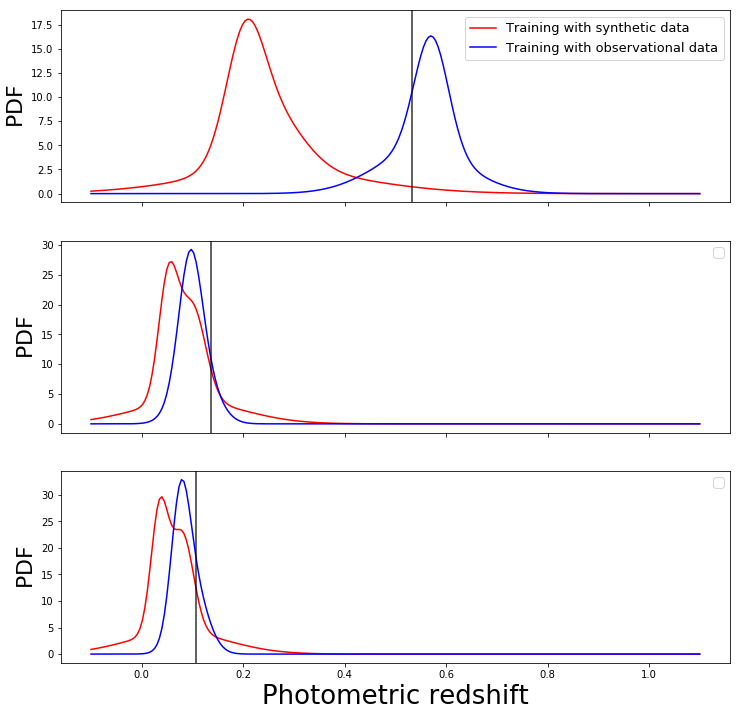

In [27]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

test_means_obs = np.array(y_pred_mean_obs[:, :, 0] )
test_std_obs = np.array(y_pred_std_obs[:, :, 0] )
test_weights_obs = np.ones_like(test_means_obs) ######## THIS needs to be corrected!!

## plotting pdfs
from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')

plot_pdfs(test_means_obs,test_weights_obs,test_std_obs, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
[420, 102, 81]
0
1
2
[420, 102, 81]
0
1
2


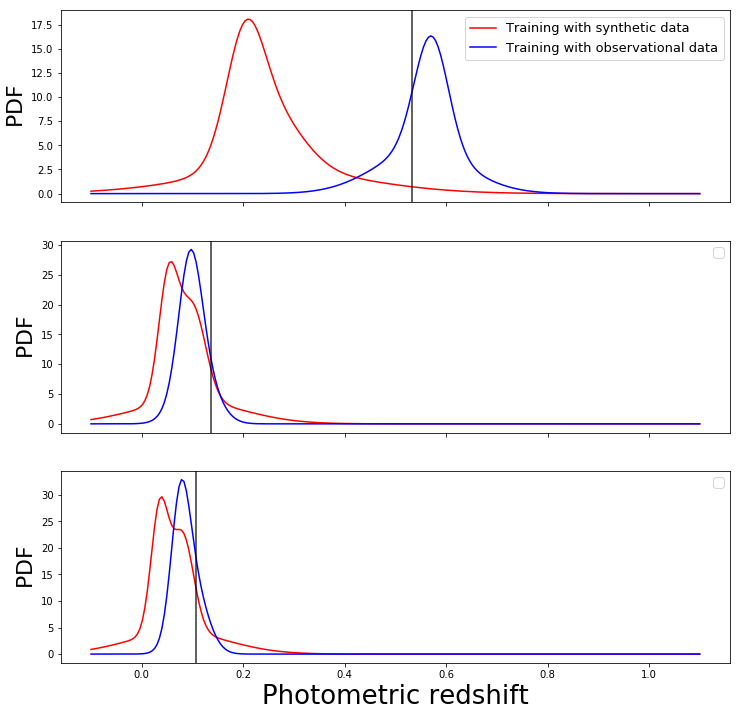

In [28]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

test_means_obs = np.array(y_pred_mean_obs[:, :, 0] )
test_std_obs = np.array(y_pred_std_obs[:, :, 0] )
test_weights_obs = np.ones_like(test_means_obs)

## plotting pdfs

from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
plot_pdfs(test_means_obs,test_weights_obs,test_std_obs, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

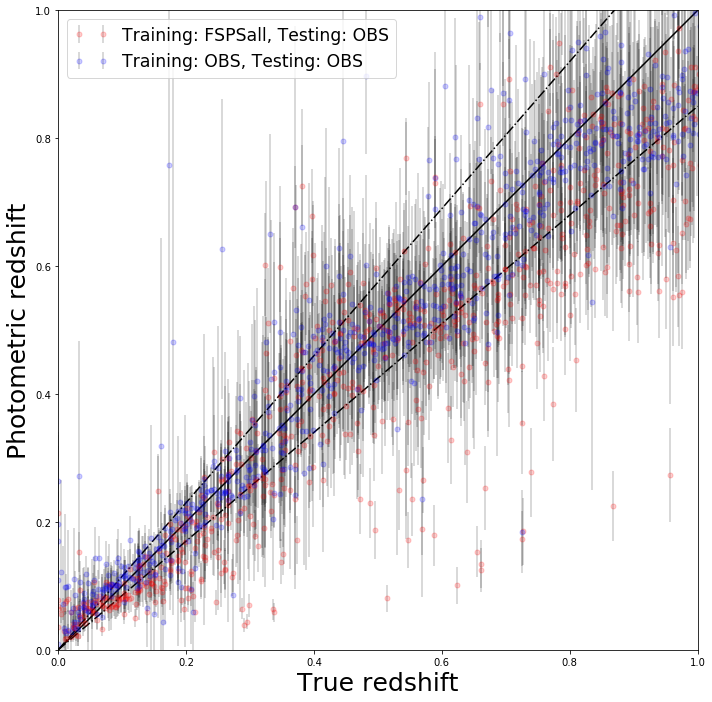

In [29]:
# fig = plt.figure(22)

def rescaley(y):
    return ymin + ((ymax-ymin)*y)

ifPlotWeighted = True

y_pred_best = np.squeeze(np.array(y_pred_mode[:, 0]))
y_pred_std_best = np.squeeze(np.array(y_pred_std[:, 0]))

y_pred_best_obs = np.squeeze(np.array(y_pred_mode_obs[:, 0]))
y_pred_std_best_obs = np.squeeze(np.array(y_pred_std_obs[:, 0]))


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10,))

    
    plt.errorbar( rescaley(y_test), rescaley(y_pred_best), yerr= rescaley(y_pred_std_best), fmt='ro', ecolor='k', ms = 5, alpha = 0.2, label = 'Training: '+Trainset + ', Testing: '+Testset)


    plt.errorbar( rescaley(y_test), rescaley(y_pred_best_obs), yerr= rescaley(y_pred_std_best_obs), fmt='bo', ecolor='k', ms = 5, alpha = 0.2, label = 'Training: '+Trainset2 + ', Testing: '+Testset)



plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')




plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)


plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


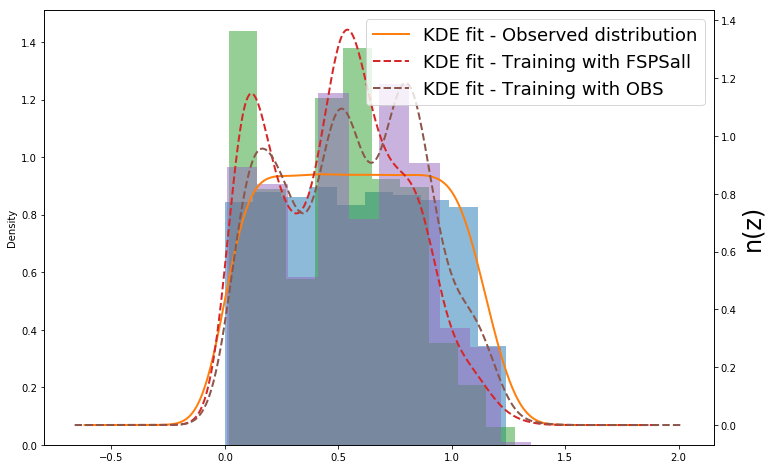

In [30]:
import pandas as pd
s = pd.Series(rescaley(y_test)).add_prefix('Obs')
s1 = pd.Series(rescaley(y_pred_best)).add_prefix('Training: '+Trainset)
s2 = pd.Series(rescaley(y_pred_best_obs)).add_prefix('Training: '+Trainset2)

plt.figure(12, figsize = (12, 8))

ax = s.plot.hist(alpha=0.5, density=10, label = 'Obs')
ax = s.plot.kde(linewidth = 2, secondary_y=True, label = 'KDE fit - Observed distribution')
ax = s1.plot.hist(alpha=0.5, density=10, label = 'Training with '+Trainset )
ax = s1.plot.kde(linewidth = 2,  secondary_y=True, linestyle = '--', label = 'KDE fit - Training with '+Trainset)
ax = s2.plot.hist(alpha=0.5, density=10, label = 'Training with '+Trainset2)
ax = s2.plot.kde(linewidth = 2, secondary_y=True, linestyle = '--', label = 'KDE fit - Training with '+Trainset2)

plt.legend(fontsize = 18)
plt.xlabel('z', fontsize = 24)
plt.ylabel('n(z)',fontsize = 24)
plt.show()

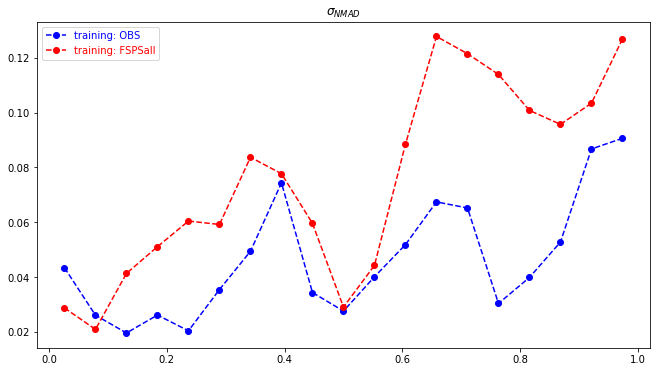

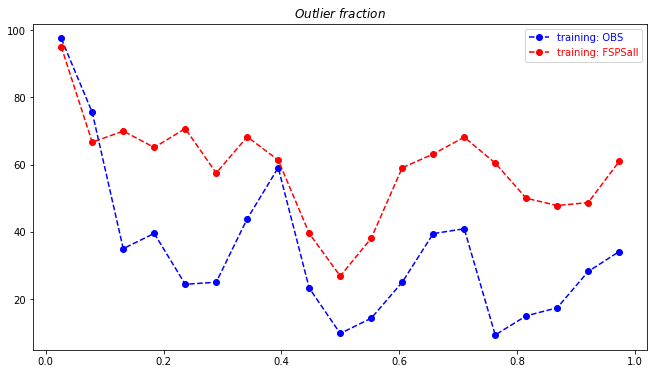

In [31]:
def sigmaNMAD(z_spec, z_pho):
    return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec))
    # else: return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec),)

def outlierFrac(z_spec, z_pho, threshold = 0.15):
    outliers = z_pho[ (np.abs(z_spec - z_pho)) >= threshold*z_spec ]
    return 100.0*len(outliers)/np.shape(z_pho)[0]

def MedianProperScore(z_spec, mu_all, sigma_all):
    ## Eq 27 in https://www.tandfonline.com/doi/pdf/10.1198/016214506000001437?needAccess=true
    ## taking median of all scores
    S_all = np.zeros_like(mu_all)
    for comp_i in range(S_all.shape[1]):
        S_all[:, comp_i] = - ((z_spec - mu_all[:, comp_i])/sigma_all[:, comp_i])**2 - np.log(sigma_all[:, comp_i]**2)
    return np.median(S_all, axis = 0)



bins = np.linspace(0, 1, 20)

z_spec = (ymax - ymin)*(ymin + y_test)
z_spec_obs = (ymax - ymin)*(ymin + y_test)

z_phot = (ymax - ymin)*(ymin + y_pred_best)
z_phot_obs = (ymax - ymin)*(ymin + y_pred_best_obs)

z_spec_digitize = np.digitize( z_spec, bins)
z_spec_digitize_obs = np.digitize( z_spec, bins)

sigmaNMAD_combine = np.zeros(shape=bins.shape[0])
outFr_combine = np.zeros(shape=bins.shape[0])
 

sigmaNMAD_obs = np.zeros(shape=bins.shape[0])
outFr_obs = np.zeros(shape=bins.shape[0])


for ind in range(bins.shape[0] - 1):
    z_spec_bin_z_obs =  z_spec_obs[ z_spec_digitize_obs  == ind + 1]
    z_phot_bin_z_obs =  z_phot_obs[ z_spec_digitize_obs  == ind + 1]
    sigmaNMAD_obs[ind] =  sigmaNMAD(z_spec_bin_z_obs, z_phot_bin_z_obs)
    outFr_obs[ind] = outlierFrac(z_spec_bin_z_obs, z_phot_bin_z_obs, 0.15)
    
    z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
    z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
    sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
    outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    

plt.figure(5232, figsize=(11,6))

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, sigmaNMAD_obs[:bins.shape[0]-1], 'bo--', label = 'training: '+Trainset2)
plt.plot(bincenter, sigmaNMAD_combine[:bins.shape[0]-1] , 'ro--', label = 'training: '+Trainset)
# plt.xscale('log')
plt.title(r'$\sigma_{NMAD}$')
leg = plt.legend()

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.figure(5233, figsize=(11,6))

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, outFr_obs[:bins.shape[0]-1], 'bo--', label = 'training: '+Trainset2)
plt.plot(bincenter, outFr_combine[:bins.shape[0]-1] , 'ro--', label = 'training: '+Trainset)
# plt.xscale('log')
plt.title(r'$Outlier$ $fraction$')
leg = plt.legend()

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)
    


[ 3.4983225  3.4250169 -3.9786878]
[3.858881 5.298824]


Text(0.5,1,'$Proper Score $')

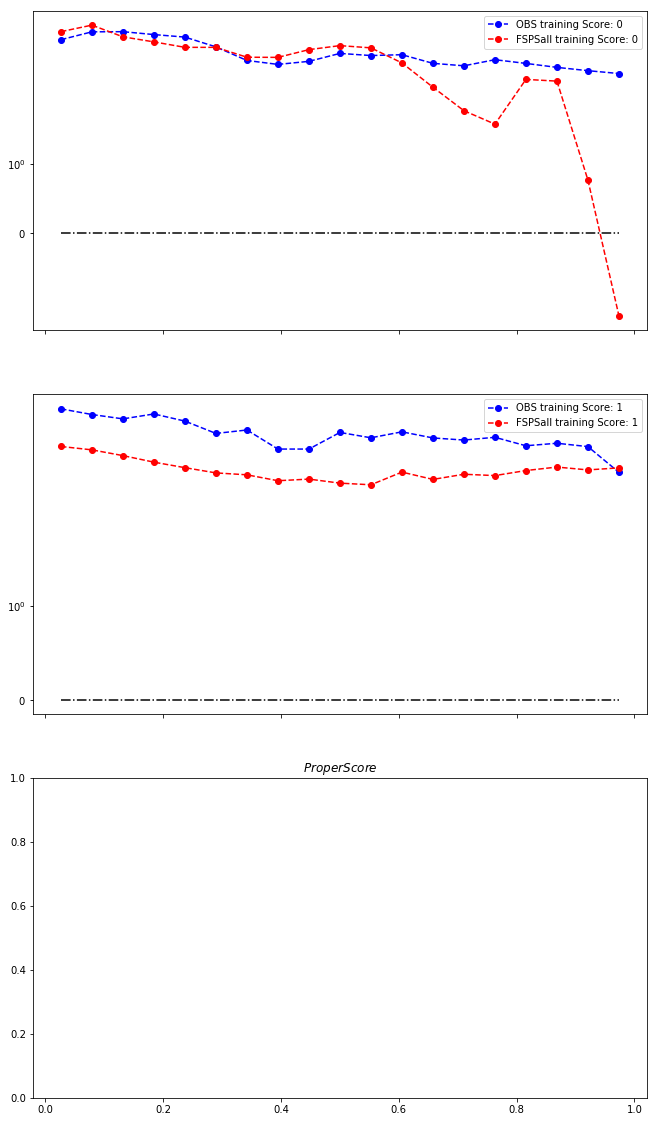

In [32]:
    
MedianProperScore_combine_all = MedianProperScore(z_spec, test_means, test_std)
MedianProperScore_obs_all = MedianProperScore(z_spec, test_means_obs, test_std_obs)

print(MedianProperScore_combine_all)
print(MedianProperScore_obs_all)



MedianProperScore_combine0 = np.zeros(shape=(bins.shape[0], K) )
MedianProperScore_obs0 = np.zeros(shape=(bins.shape[0], K2) )


for ind in range(bins.shape[0] - 1):
    z_spec_bin_z_obs =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z_obs =  test_means_obs[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z_obs =  test_std_obs[ z_spec_digitize  == ind + 1, :]
    MedianProperScore_obs0[ind] =  MedianProperScore(z_spec_bin_z_obs, test_means_bin_z_obs, test_std_bin_z_obs)
    
#     z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
#     z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
#     sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
#     outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    
    z_spec_bin_z =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z =  test_means[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z =  test_std[ z_spec_digitize  == ind + 1, :]
    MedianProperScore_combine0[ind] =  MedianProperScore(z_spec_bin_z, test_means_bin_z, test_std_bin_z)
    
    
    
fig, ax = plt.subplots(3,1, figsize=(11,20), sharex=True)

bincenter = (bins[1:] + bins[:-1]) / 2.

for score_ind in range(K2):
    ax[score_ind].plot(bincenter, MedianProperScore_obs0[:bins.shape[0]-1, score_ind], 'bo--', label = Trainset2+ ' training ' + 'Score: ' + str(score_ind))
    ax[score_ind].plot(bincenter, MedianProperScore_combine0[:bins.shape[0]-1, score_ind] , 'ro--', label = Trainset+ ' training ' + 'Score: ' + str(score_ind))
#     ax[score_ind].set_xscale('log')
    ax[score_ind].plot([bincenter[0], bincenter[-1]], [0, 0], 'k-.')
    ax[score_ind].set_yscale('symlog')
    leg = ax[score_ind].legend()
    
plt.title(r'$Proper Score $')


In [33]:
def WeightedMedianProperScore(z_spec, mu_all, sigma_all, weights_all):
    ## Eq 27 in https://www.tandfonline.com/doi/pdf/10.1198/016214506000001437?needAccess=true
    ## taking median of all scores
    S_all = np.zeros_like(mu_all)
    for comp_i in range(S_all.shape[1]):
        S_all[:, comp_i] = - ((z_spec - mu_all[:, comp_i])/sigma_all[:, comp_i])**2 - np.log(sigma_all[:, comp_i]**2)
        
    WeightedS = 1.0
    for Kind in np.arange(S_all.shape[1]):
        WeightedS *= weights_all[:, Kind]*S_all[:, Kind] #* weights_all[:, 1]*S_all[:, 1] * weights_all[:, 2]*S_all[:, 2]
#     print(WeightedS.shape)
    return np.median(WeightedS , axis = 0)



obs weighted proper score 1.86e+01
synthetic weighted proper score 4.90e+01


Text(0.5,1,'$Weighted Proper Score $')

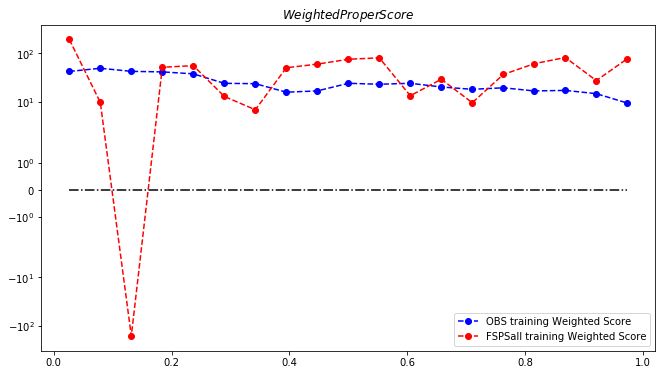

In [34]:
print('obs weighted proper score %.2e'%WeightedMedianProperScore(z_spec, test_means_obs, test_std_obs, test_weights_obs))
print('synthetic weighted proper score %.2e'%WeightedMedianProperScore(z_spec, test_means, test_std, test_weights))



WeightedMedianProperScore_combine0 = np.zeros(shape=(bins.shape[0]) )
WeightedMedianProperScore_obs0 = np.zeros(shape=(bins.shape[0]) )


for ind in range(bins.shape[0] - 1):
    z_spec_bin_z_obs =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z_obs =  test_means_obs[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z_obs =  test_std_obs[ z_spec_digitize  == ind + 1, :]
    test_weights_bin_z_obs =  test_weights_obs[ z_spec_digitize_obs  == ind + 1, :]
    
    WeightedMedianProperScore_obs0[ind] =  WeightedMedianProperScore(z_spec_bin_z_obs, test_means_bin_z_obs, test_std_bin_z_obs,  test_weights_bin_z_obs)
    
#     z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
#     z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
#     sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
#     outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    
    z_spec2_bin_z =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z =  test_means[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z =  test_std[ z_spec_digitize  == ind + 1, :]
    test_weights_bin_z =  test_weights[ z_spec_digitize  == ind + 1, :]
    
    WeightedMedianProperScore_combine0[ind] =  WeightedMedianProperScore(z_spec2_bin_z, test_means_bin_z, test_std_bin_z, test_weights_bin_z)
    
    
    
# fig, ax = plt.subplots(1,1, figsize=(11,20), sharex=True)

plt.figure(52553, figsize=(11,6))
bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, WeightedMedianProperScore_obs0[:bins.shape[0]-1], 'bo--', label = Trainset2+' training ' + 'Weighted Score')
plt.plot(bincenter, WeightedMedianProperScore_combine0[:bins.shape[0]-1] , 'ro--', label = Trainset +' training ' + 'Weighted Score')
# ax[score_ind].set_xscale('log')
plt.plot([bincenter[0], bincenter[-1]], [0, 0], 'k-.')
plt.yscale('symlog')
leg = plt.legend()
    
plt.title(r'$Weighted Proper Score $')
